In [88]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
sns.set(style="ticks")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import statsmodels.api as sm

In [2]:
df_customer = pd.read_csv('brazilian-ecommerce_2020/olist_customers_dataset.csv')
df_geolocation = pd.read_csv('brazilian-ecommerce_2020/olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('brazilian-ecommerce_2020/olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('brazilian-ecommerce_2020/olist_order_payments_dataset.csv')
df_order_reviews = pd.read_csv('brazilian-ecommerce_2020/olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('brazilian-ecommerce_2020/olist_orders_dataset.csv')
df_products = pd.read_csv('brazilian-ecommerce_2020/olist_products_dataset.csv')
df_sellers = pd.read_csv('brazilian-ecommerce_2020/olist_sellers_dataset.csv')
df_product_category_name_translation = pd.read_csv('brazilian-ecommerce_2020/product_category_name_translation.csv')

## Clean Data

In [3]:
table_dict = {'Customer':df_customer, 'Geolocation':df_geolocation, 
              'Order Items':df_order_items, 'Order Payments':df_order_payments, 
              'Order Reviews':df_order_reviews, 'Orders Details':df_orders, 
              'Products':df_products,'Sellers': df_sellers}

In [4]:
def summary(df):
    list_item = []
    for col in df.columns:
        list_item.append([col, df[col].dtype, df[col].isna().sum(), 100*df[col].isna().sum()/len(df[col]), df[col].nunique(), df[col].unique()[:4]])
    desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
    return desc_df

def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):
    
    # Preparing variables
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    #fig, ax = plt.subplots()
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Setting borders
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

### Products

In [5]:
df_products.shape

(32951, 9)

In [6]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [7]:
df_products.to_csv('clean_data/products.csv')

In [8]:
df_products = df_products.merge(df_product_category_name_translation, how = 'left', on = 'product_category_name')

In [9]:
df_products = df_products.drop('product_category_name', axis = 1).rename({'product_category_name_english':'product_category_name'}, axis = 1)
df_products['product_category_name'] = df_products['product_category_name'].fillna('others')

### Customers

In [10]:
summary(df_customer)

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,customer_id,object,0,0.0,99441,"[06b8999e2fba1a1fbc88172c00ba8bc7, 18955e83d33..."
1,customer_unique_id,object,0,0.0,96096,"[861eff4711a542e4b93843c6dd7febb0, 290c77bc529..."
2,customer_zip_code_prefix,int64,0,0.0,14994,"[14409, 9790, 1151, 8775]"
3,customer_city,object,0,0.0,4119,"[franca, sao bernardo do campo, sao paulo, mog..."
4,customer_state,object,0,0.0,27,"[SP, SC, MG, PR]"


### Geolocation

In [11]:
summary(df_geolocation)

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,geolocation_zip_code_prefix,int64,0,0.0,19015,"[1037, 1046, 1041, 1035]"
1,geolocation_lat,float64,0,0.0,717360,"[-23.54562128115268, -23.54608112703553, -23.5..."
2,geolocation_lng,float64,0,0.0,717613,"[-46.63929204800168, -46.64482029837157, -46.6..."
3,geolocation_city,object,0,0.0,8011,"[sao paulo, são paulo, sao bernardo do campo, ..."
4,geolocation_state,object,0,0.0,27,"[SP, RN, AC, RJ]"


In [22]:
df_geolocation[df_geolocation['geolocation_zip_code_prefix'] == 1001]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
99,1001,-23.549292,-46.633559,sao paulo,SP
206,1001,-23.550498,-46.634338,sao paulo,SP
235,1001,-23.550642,-46.634410,sao paulo,SP
299,1001,-23.549698,-46.633909,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP
429,1001,-23.550498,-46.634338,sao paulo,SP
519,1001,-23.551337,-46.634027,sao paulo,SP
575,1001,-23.549779,-46.633957,são paulo,SP
583,1001,-23.551337,-46.634027,sao paulo,SP
596,1001,-23.550498,-46.634338,sao paulo,SP


### Order Items

In [12]:
summary(df_order_items)

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,order_id,object,0,0.0,98666,"[00010242fe8c5a6d1ba2dd792cb16214, 00018f77f2f..."
1,order_item_id,int64,0,0.0,21,"[1, 2, 3, 4]"
2,product_id,object,0,0.0,32951,"[4244733e06e7ecb4970a6e2683c13e61, e5f2d52b802..."
3,seller_id,object,0,0.0,3095,"[48436dade18ac8b2bce089ec2a041202, dd7ddc04e1b..."
4,shipping_limit_date,object,0,0.0,93318,"[2017-09-19 09:45:35, 2017-05-03 11:05:13, 201..."
5,price,float64,0,0.0,5968,"[58.9, 239.9, 199.0, 12.99]"
6,freight_value,float64,0,0.0,6999,"[13.29, 19.93, 17.87, 12.79]"


<BarContainer object of 17 artists>

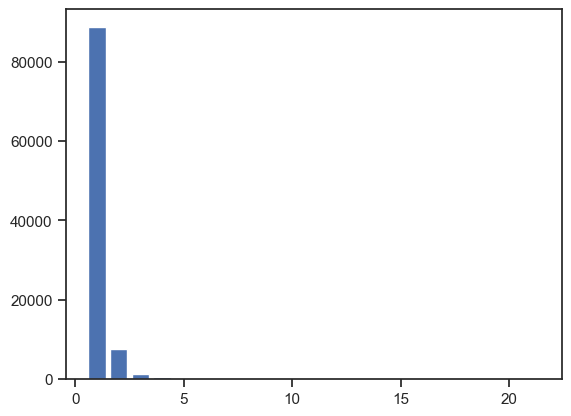

In [13]:
rs = df_order_items.groupby('order_id')['order_item_id'].max().reset_index()
plt.bar('order_item_id',height = 'count',data = rs['order_item_id'].value_counts().reset_index())

In [56]:
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


### Order Payments

In [14]:
summary(df_order_payments)

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,order_id,object,0,0.0,99440,"[b81ef226f3fe1789b1e8b2acac839d17, a9810da8291..."
1,payment_sequential,int64,0,0.0,29,"[1, 2, 4, 5]"
2,payment_type,object,0,0.0,5,"[credit_card, boleto, voucher, debit_card]"
3,payment_installments,int64,0,0.0,24,"[8, 1, 2, 3]"
4,payment_value,float64,0,0.0,29077,"[99.33, 24.39, 65.71, 107.78]"


In [15]:
df_order_payments.describe(include = 'all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
count,103886,103886.000000,103886,103886.000000,103886.000000
unique,99440,NaN,5,NaN,NaN
top,fa65dad1b0e818e3ccc5cb0e39231352,NaN,credit_card,NaN,NaN
freq,29,NaN,76795,NaN,NaN
mean,NaN,1.092679,NaN,2.853349,154.100380
std,NaN,0.706584,NaN,2.687051,217.494064
min,NaN,1.000000,NaN,0.000000,0.000000
25%,NaN,1.000000,NaN,1.000000,56.790000
50%,NaN,1.000000,NaN,1.000000,100.000000
75%,NaN,1.000000,NaN,4.000000,171.837500


### Orders Review

In [16]:
summary(df_order_reviews)

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,review_id,object,0,0.000,99173,"[7bc2406110b926393aa56f80a40eba40, 80e641a11e5..."
1,order_id,object,0,0.000,99441,"[73fc7af87114b39712e6da79b0a377eb, a548910a1c6..."
2,review_score,int64,0,0.000,5,"[4, 5, 1, 3]"
3,review_comment_title,object,88285,88.285,4600,"[nan, recomendo, Super recomendo, Não chegou m..."
4,review_comment_message,object,58247,58.247,36921,"[nan, Recebi bem antes do prazo estipulado., P..."
5,review_creation_date,object,0,0.000,637,"[2018-01-18 00:00:00, 2018-03-10 00:00:00, 201..."
6,review_answer_timestamp,object,0,0.000,99010,"[2018-01-18 21:46:59, 2018-03-11 03:05:13, 201..."


In [17]:
df_order_reviews.isnull().any()

review_id                  False
order_id                   False
review_score               False
review_comment_title        True
review_comment_message      True
review_creation_date       False
review_answer_timestamp    False
dtype: bool

In [18]:
df_order_reviews[df_order_reviews['review_id'] == '']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp


In [19]:
df_order_reviews['review_id'].value_counts()

review_id
2172867fd5b1a55f98fe4608e1547b4b    3
abbfacb2964f74f6487c9c10ac46daa6    3
2d6ac45f859465b5c185274a1c929637    3
832acec9bbf4efe65c3fb6423d8b4ed7    3
4219a80ab469e3fc9901437b73da3f75    3
                                   ..
1ee1ab82bfc7812f9bc3fc13eed58c38    1
3206a2afb959946a223eafa1f972efb1    1
601080b8c0cb7f308e9560435e89b229    1
20ca25b79aecd18e0d5bb142ac83481c    1
efe49f1d6f951dd88b51e6ccd4cc548f    1
Name: count, Length: 99173, dtype: int64

### Orders 

In [14]:
summary(df_orders)

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,order_id,object,0,0.000000,99441,"[e481f51cbdc54678b7cc49136f2d6af7, 53cdb2fc8bc..."
1,customer_id,object,0,0.000000,99441,"[9ef432eb6251297304e76186b10a928d, b0830fb4747..."
2,order_status,object,0,0.000000,8,"[delivered, invoiced, shipped, processing]"
3,order_purchase_timestamp,object,0,0.000000,98875,"[2017-10-02 10:56:33, 2018-07-24 20:41:37, 201..."
4,order_approved_at,object,160,0.160899,90733,"[2017-10-02 11:07:15, 2018-07-26 03:24:27, 201..."
5,order_delivered_carrier_date,object,1783,1.793023,81018,"[2017-10-04 19:55:00, 2018-07-26 14:31:00, 201..."
6,order_delivered_customer_date,object,2965,2.981668,95664,"[2017-10-10 21:25:13, 2018-08-07 15:27:45, 201..."
7,order_estimated_delivery_date,object,0,0.000000,459,"[2017-10-18 00:00:00, 2018-08-13 00:00:00, 201..."


In [15]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [16]:
df_orders[(df_orders['order_approved_at'].isnull()) & (df_orders['order_status'] == 'delivered')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaN,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17 00:00:00
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaN,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21 00:00:00
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaN,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17 00:00:00
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaN,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31 00:00:00
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaN,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20 00:00:00
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaN,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01 00:00:00
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaN,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27 00:00:00
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaN,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22 00:00:00
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaN,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16 00:00:00
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaN,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20 00:00:00


In [17]:
list_date_col =  ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
for col in list_date_col: 
    df_orders[col] =  pd.to_datetime(df_orders[col], format = '%Y-%m-%d %H:%M:%S')

In [18]:
df_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [19]:
df_orders['purchase_to_approved'] = (df_orders['order_approved_at'] - df_orders['order_purchase_timestamp']).dt.total_seconds()/3600
df_orders['seller_to_carrier'] = (df_orders['order_delivered_carrier_date'] - df_orders['order_approved_at']).dt.total_seconds()/3600
df_orders['carrier_to_customer'] = (df_orders['order_delivered_customer_date'] - df_orders['order_delivered_carrier_date']).dt.total_seconds()/3600
df_orders['delivery_time_hours'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']).dt.total_seconds()/3600
df_orders['delivery_time_days'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']).dt.days
df_orders['estimate_delivery_time_days'] = (df_orders['order_estimated_delivery_date'] - df_orders['order_purchase_timestamp']).dt.days

In [20]:
mean_hour = df_orders['purchase_to_approved'].mean()

In [21]:
df_orders.loc[df_orders['order_status'] == 'delivered','order_approved_at'] = df_orders.loc[df_orders['order_status'] == 'delivered','order_approved_at'].fillna(pd.to_datetime(df_orders['order_purchase_timestamp']) + pd.Timedelta(hours=mean_hour))

In [22]:
df_orders[df_orders['order_delivered_carrier_date'].isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_to_approved,seller_to_carrier,carrier_to_customer,delivery_time_hours,delivery_time_days,estimate_delivery_time_days
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,49.052500,NaN,NaN,NaN,NaN,27
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,84.508889,NaN,NaN,NaN,NaN,17
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,0.135000,NaN,NaN,NaN,NaN,29
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,0.291389,NaN,NaN,NaN,NaN,18
324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaT,NaT,2016-12-09,17.114444,NaN,NaN,NaN,NaN,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01,NaN,NaN,NaN,NaN,NaN,30
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06,80.178056,NaN,NaN,NaN,NaN,31
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27,NaN,NaN,NaN,NaN,NaN,20
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15,119.278611,NaN,NaN,NaN,NaN,22


### Sellers

In [57]:
summary(df_sellers)

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,seller_id,object,0,0.0,3095,"[3442f8959a84dea7ee197c632cb2df15, d1b65fc7deb..."
1,seller_zip_code_prefix,int64,0,0.0,2246,"[13023, 13844, 20031, 4195]"
2,seller_city,object,0,0.0,611,"[campinas, mogi guacu, rio de janeiro, sao paulo]"
3,seller_state,object,0,0.0,23,"[SP, RJ, PE, PR]"


In [58]:
df_sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [61]:
df_geolocation[df_geolocation['geolocation_zip_code_prefix'] == 13023]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
285371,13023,-22.898536,-47.063125,campinas,SP
285380,13023,-22.895499,-47.061944,campinas,SP
285470,13023,-22.891740,-47.060820,campinas,SP
285511,13023,-22.895762,-47.066144,campinas,SP
285528,13023,-22.896154,-47.062431,campinas,SP
...,...,...,...,...,...
289989,13023,-22.891019,-47.060365,campinas,SP
290191,13023,-22.891836,-47.062373,campinas,SP
290254,13023,-22.897888,-47.064010,campinas,SP
290308,13023,-22.900175,-47.063856,campinas,SP


In [23]:
# for table_name, df in table_dict.items():
#     table = table_name.lower().replace(' ','_')
#     df.to_csv(f'clean_data/{table}.csv')

# Analysis

In [24]:
df_products['volume_cm3'] = df_products['product_length_cm']*df_products['product_height_cm']*df_products['product_width_cm']

In [25]:
#Merge table
df_train = df_order_items.merge(df_orders, on = 'order_id',how = 'inner')
df_train = df_train.merge(df_order_reviews, on = 'order_id', how =  'inner')
df_train = df_train.merge(df_order_payments, on = 'order_id', how =  'inner')
df_train = df_train.merge(df_products, on = 'product_id', how =  'inner').drop(
    ['product_length_cm','product_height_cm','product_width_cm'], axis = 1)
df_train = df_train.merge(df_customer, on = 'customer_id', how =  'inner')
df_train = df_train.merge(df_sellers, on = 'seller_id', how =  'inner')
df_train

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,product_weight_g,product_category_name,volume_cm3,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,650.0,cool_stuff,3528.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,27277,volta redonda,SP
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,30000.0,pet_shop,60000.0,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,3471,sao paulo,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,3050.0,furniture_decor,14157.0,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,37564,borda da mata,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,200.0,perfumery,2400.0,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,14403,franca,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,3750.0,garden_tools,42000.0,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,87900,loanda,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,b51593916b4b8e0d6f66f2ae24f2673d,delivered,2018-04-23 13:57:06,...,10150.0,housewares,53400.0,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,88303,itajai,SC
118311,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,84c5d4fbaf120aae381fad077416eaa0,delivered,2018-07-14 10:26:46,...,8950.0,computers_accessories,44460.0,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,1206,sao paulo,SP
118312,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,29309aa813182aaddc9b259e31b870e6,delivered,2017-10-23 17:07:56,...,967.0,sports_leisure,9576.0,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,80610,curitiba,PR
118313,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,b5e6afd5a41800fdf401e0272ca74655,delivered,2017-08-14 23:02:59,...,100.0,computers_accessories,8000.0,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,4733,sao paulo,SP


In [26]:
df_train['year'] = df_train.order_purchase_timestamp.apply(lambda x: x.year)
df_train['month'] = df_train.order_purchase_timestamp.apply(lambda x: x.month)
df_train['dayofweek'] = df_train.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df_train['hour'] = df_train.order_purchase_timestamp.apply(lambda x: x.hour)
df_train['day'] = df_train['dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df_train['_mon'] = df_train.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
df_train['order_count']=1
df_train['year_month'] = df_train['order_purchase_timestamp'].dt.strftime('%Y-%m')
df_train.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,seller_city,seller_state,year,month,dayofweek,hour,day,_mon,order_count,year_month
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,volta redonda,SP,2017,9,2,8,Wed,Sep,1,2017-09
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,sao paulo,SP,2017,4,2,10,Wed,Apr,1,2017-04
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,borda da mata,MG,2018,1,6,14,Sun,Jan,1,2018-01


In [27]:
summary(df_train)

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,order_id,object,0,0.000000,98665,"[00010242fe8c5a6d1ba2dd792cb16214, 00018f77f2f..."
1,order_item_id,int64,0,0.000000,21,"[1, 2, 3, 4]"
2,product_id,object,0,0.000000,32951,"[4244733e06e7ecb4970a6e2683c13e61, e5f2d52b802..."
3,seller_id,object,0,0.000000,3095,"[48436dade18ac8b2bce089ec2a041202, dd7ddc04e1b..."
4,shipping_limit_date,object,0,0.000000,93317,"[2017-09-19 09:45:35, 2017-05-03 11:05:13, 201..."
5,price,float64,0,0.000000,5968,"[58.9, 239.9, 199.0, 12.99]"
6,freight_value,float64,0,0.000000,6999,"[13.29, 19.93, 17.87, 12.79]"
7,customer_id,object,0,0.000000,98665,"[3ce436f183e68e07877b285a838db11a, f6dd3ec061d..."
8,order_status,object,0,0.000000,7,"[delivered, shipped, canceled, invoiced]"
9,order_purchase_timestamp,datetime64[ns],0,0.000000,98111,"[2017-09-13 08:59:02, 2017-04-26 10:53:06, 201..."


## Customer Retention

Từ phân tích EDA trên PBI => Ta thấy số lượng Customer mới giảm từ đầu năm 2018. Ta sẽ đi tìm hiểu nguyên nhân này, ta kiểm tra xem lượng khách hàng tại các bang có xu hướng giảm như thế nào ? 

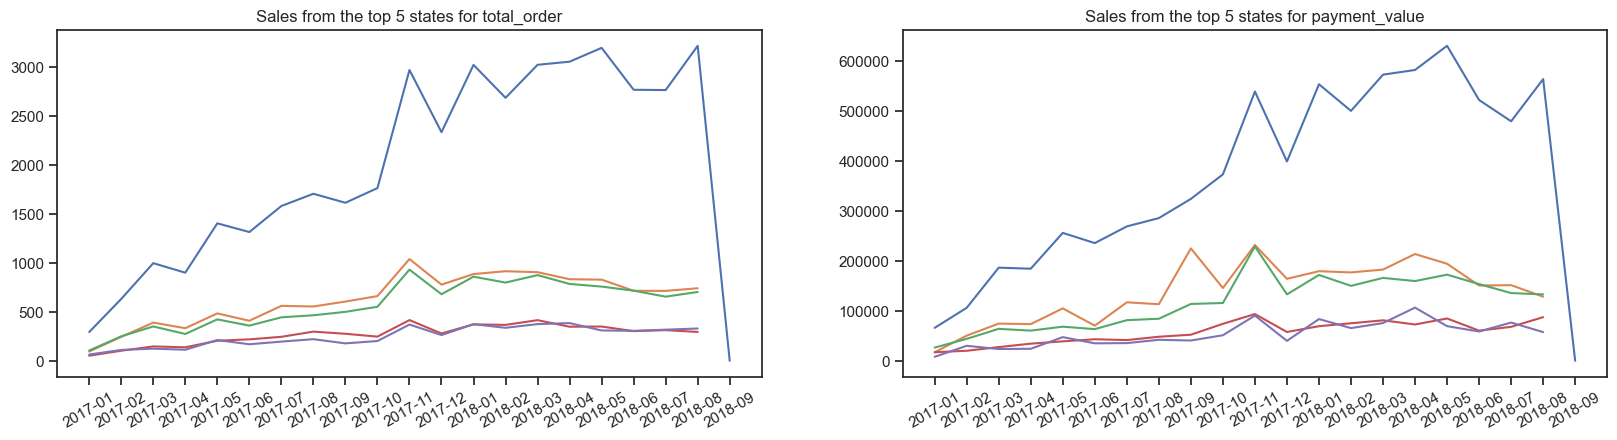

In [28]:
df_cus_state = df_train[['year','customer_state','year_month','payment_value','order_id']].groupby(
    ['customer_state','year_month','year'], as_index=False).agg({'order_id': 'nunique', 'payment_value': 'sum'}).rename(
    {'order_id':'total_order'},axis = 1)
top5 = ['SP', 'RJ','MG','RS','PR']
df_top5_state = df_cus_state.loc[(df_cus_state['customer_state'].isin(top5)) & (df_cus_state['year'] > 2016)]

fig, ax = plt.subplots(1, 2, figsize=(20, 4.5))
for i, col in enumerate(['total_order', 'payment_value']):
    for state in top5:
        data_ = df_top5_state[df_top5_state['customer_state'] == state].sort_values(by='year_month', ascending=True)
        ax[i].plot(data_['year_month'], data_[col], label=state)
    ax[i].set_title('Sales from the top 5 states for ' + col)
    ax[i].tick_params(axis='x', rotation=30)

plt.show()

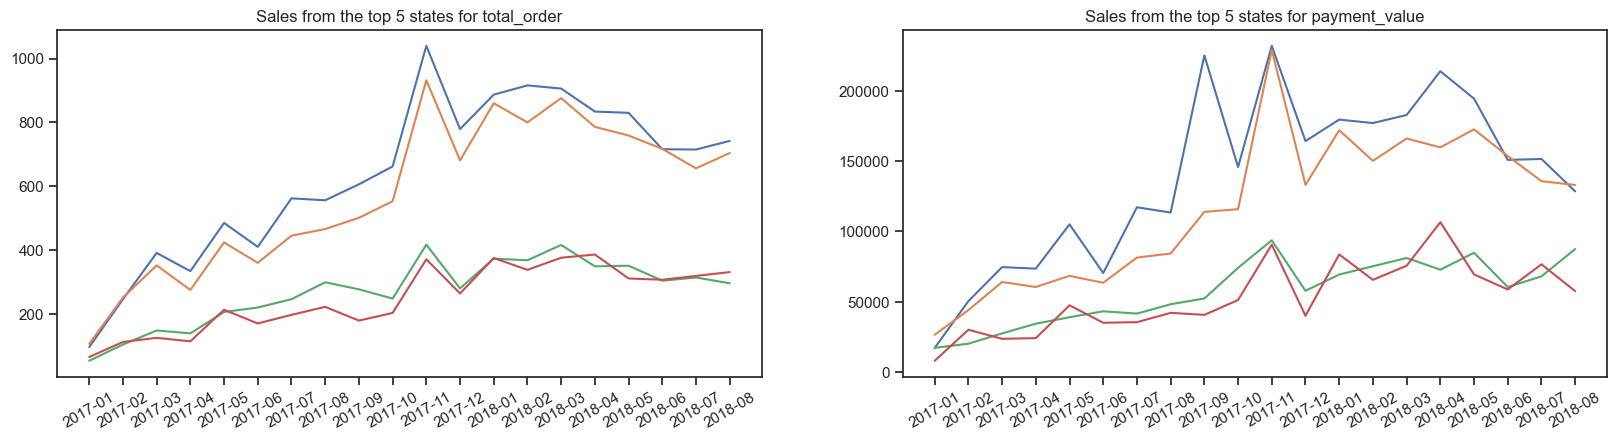

In [29]:
df_cus_state = df_train[['year','customer_state','year_month','payment_value','order_id']].groupby(
    ['customer_state','year_month','year'], as_index=False).agg({'order_id': 'nunique', 'payment_value': 'sum'}).rename(
    {'order_id':'total_order'},axis = 1)
top5 = ['RJ','MG','RS','PR']
df_top5_state = df_cus_state.loc[(df_cus_state['customer_state'].isin(top5)) & (df_cus_state['year'] > 2016)]

fig, ax = plt.subplots(1, 2, figsize=(20, 4.5))
for i, col in enumerate(['total_order', 'payment_value']):
    for state in top5:
        data_ = df_top5_state[df_top5_state['customer_state'] == state].sort_values(by='year_month', ascending=True)
        ax[i].plot(data_['year_month'], data_[col], label=state)
    ax[i].set_title('Sales from the top 5 states for ' + col)
    ax[i].tick_params(axis='x', rotation=30)

plt.show()

In [30]:
df_top5_state[df_top5_state['customer_state'] == 'SP']

,customer_state,year_month,year,total_order,payment_value


Ta thấy chỉ có duy nhất SP có tăng trưởng nhẹ đầu năm 2018 đạt cao nhất 630506 tháng 05/2018 sau đó giảm 17% trong tháng 06/2018 (còn 522037). 4 thành phố top đầu còn lại đều cho thấy xu hướng đi xuống trong năm 2018.

In [77]:
# Tính số lượng khách hàng mới và cũ trong mỗi tháng
df_train['is_new_customer'] = df_train.groupby('customer_unique_id')['year_month'].transform('min') == df_train['year_month']
new_customers = df_train[df_train['is_new_customer']].groupby('year_month')['customer_unique_id'].nunique()
old_customers = df_train[~df_train['is_new_customer']].groupby('year_month')['customer_unique_id'].nunique()

# Tính Churn_rate theo tháng
churn_rate = 100*(1 - new_customers / (new_customers + old_customers))
churn_rate.dropna()

year_month
2017-01    0.132450
2017-02    0.175644
2017-03    0.230681
2017-04    0.847817
2017-05    0.780379
2017-06    1.268231
2017-07    1.309707
2017-08    1.472334
2017-09    1.918465
2017-10    1.977338
2017-11    1.702533
2017-12    2.069462
2018-01    1.924157
2018-02    1.759217
2018-03    2.099775
2018-04    2.457110
2018-05    2.810890
2018-06    3.055056
2018-07    2.527773
2018-08    2.698487
Name: customer_unique_id, dtype: float64

In [32]:
# Cohort Analysis
df_user_purchase = df_train.groupby(['customer_unique_id','year_month'])['payment_value'].count().reset_index()
df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['year_month']).reset_index()
df_retention.head()

year_month,customer_unique_id,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
0,0000366f3b9a7992bf8c76cfdf3221e2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0000f46a3911fa3c0805444483337064,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
months = df_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['year_month'] = str(selected_month)
    retention_data['Total_user_count'] = df_retention[selected_month].sum()
    retention_data['Retained_user_count'] = df_retention[(df_retention[selected_month]>0) & (df_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
df_retention_final = pd.DataFrame(retention_array)
df_retention_final['Retention_rate'] = 100*(df_retention_final['Retained_user_count']/df_retention_final['Total_user_count'])

df_retention_final = df_retention_final[df_retention_final['year_month'] != '2018-09']
df_retention_final

,year_month,Total_user_count,Retained_user_count,Retention_rate
0,2016-12,1,0,0.000000
1,2017-01,755,1,0.132450
2,2017-02,1708,3,0.175644
3,2017-03,2601,4,0.153787
4,2017-04,2359,13,0.551081
5,2017-05,3588,14,0.390190
6,2017-06,3154,17,0.538998
7,2017-07,3894,17,0.436569
8,2017-08,4211,23,0.546189
9,2017-09,4170,32,0.767386


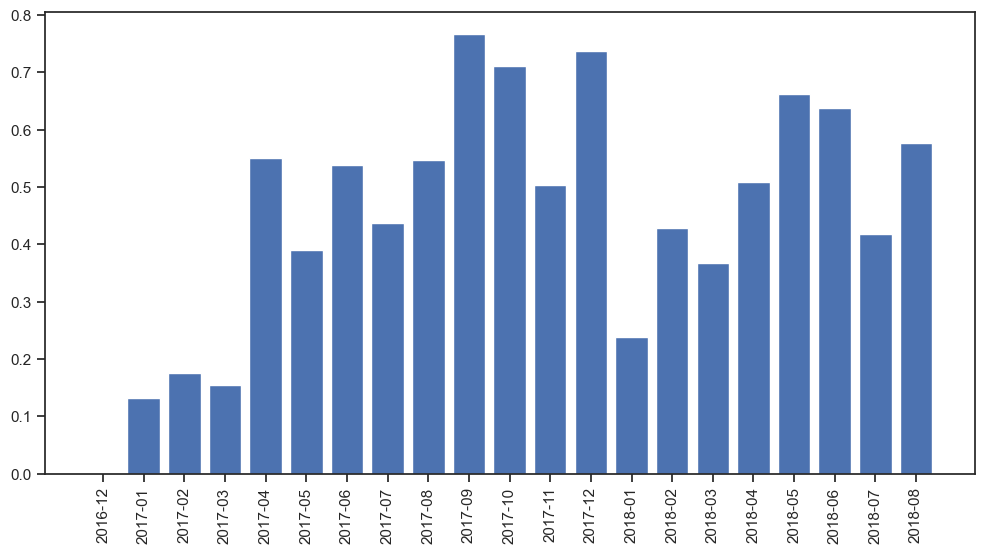

In [34]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.set( color_codes=True, style='whitegrid')
plt.bar(df_retention_final['year_month'], df_retention_final['Retention_rate'])
# bar_plot(x='year_month', y='Retention_rate', df=df_retention_final, value=True)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [35]:
df_retention = pd.crosstab(df_user_purchase['customer_unique_id'], df_user_purchase['year_month']).reset_index()
new_column_names = [ 'm_' + str(column).replace('-','_') for column in df_retention.columns]
df_retention.columns = new_column_names

In [36]:
months = [x.replace('-','_') for x in months]


In [37]:
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count = retention_data['Total_user_count'] = df_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    query = "{} > 0".format('m_' + str(selected_month))
    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(df_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
df_retention = pd.DataFrame(retention_array)
df_retention.index = months

#showing new cohort based retention table
pd.set_option('display.max_columns', None)
df_retention

,Total_user_count,2016_10,2016_12,2017_01,2017_02,2017_03,2017_04,2017_05,2017_06,2017_07,2017_08,2017_09,2017_10,2017_11,2017_12,2018_01,2018_02,2018_03,2018_04,2018_05,2018_06,2018_07,2018_08,2018_09
2016_10,305,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0
2016_12,1,NaN,1.0,1.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0
2017_01,755,NaN,NaN,1.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0
2017_02,1708,NaN,NaN,NaN,1.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0
2017_03,2601,NaN,NaN,NaN,NaN,1.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0
2017_04,2359,NaN,NaN,NaN,NaN,NaN,1.0,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0
2017_05,3588,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0
2017_06,3154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0
2017_07,3894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0
2017_08,4211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.01,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0


In [182]:
#Recency - Frequency - Monetary 

In [42]:
old_customer = df_train[~df_train['is_new_customer']]
old_customer = df_train[df_train['customer_unique_id'].isin(old_customer['customer_unique_id'].unique())]

In [62]:
groupby_old_customer = old_customer.groupby(['customer_unique_id','order_id'])[['payment_value','delivery_time_days','review_score']].mean().reset_index()

In [47]:
groupby_old_customer = groupby_old_customer.groupby('customer_unique_id').agg(
    {'order_id':'nunique','payment_value':'mean','delivery_time_days':'mean','review_score':'mean'}).reset_index()

In [54]:
groupby_old_customer.describe()

,order_id,payment_value,delivery_time_days,review_score
count,1749.000000,1749.000000,1747.000000,1749.000000
mean,2.163522,144.180813,11.496848,4.227069
std,0.620600,129.617399,6.654051,0.977007
min,2.000000,6.848036,1.000000,1.000000
25%,2.000000,73.000000,7.000000,3.500000
50%,2.000000,112.920000,10.000000,4.500000
75%,2.000000,172.465000,14.416667,5.000000
max,16.000000,2026.540000,48.000000,5.000000


In [52]:
df_train[['delivery_time_days','payment_value','review_score']].describe()

,delivery_time_days,payment_value,review_score
count,115727.000000,118315.000000,118315.000000
mean,12.021931,172.575651,4.014554
std,9.452598,267.104661,1.400186
min,0.000000,0.000000,1.000000
25%,6.000000,60.850000,3.000000
50%,10.000000,108.200000,5.000000
75%,15.000000,189.260000,5.000000
max,209.000000,13664.080000,5.000000


In [74]:
groupby_product_old_customer = old_customer.groupby('product_category_name')[['payment_value','delivery_time_days','review_score','order_id']].agg(
    {'payment_value':'sum','delivery_time_days':'mean','review_score':'mean','order_id':'nunique'}
).reset_index().sort_values(by='order_id',ascending = False)
total_order = groupby_product_old_customer['order_id'].sum()
groupby_product_old_customer['pct_total'] = 100*(groupby_product_old_customer['order_id']/total_order)
groupby_product_old_customer.head(5) #['pct_total'].sum()

,product_category_name,payment_value,delivery_time_days,review_score,order_id,pct_total
7,bed_bath_table,96836.87,11.133929,4.151026,471,12.243306
60,sports_leisure,68845.60,10.334792,4.274468,386,10.033793
40,health_beauty,52554.27,10.745152,4.264305,319,8.292176
36,furniture_decor,59981.76,11.298795,4.168646,296,7.694307
46,housewares,45040.54,9.185759,4.185410,239,6.212633


In [68]:
groupby_old_customer = old_customer.groupby('customer_unique_id')[['order_id','product_category_name']].nunique()
(groupby_old_customer['order_id']/groupby_old_customer['product_category_name']).mean()

1.3821802935010483

In [76]:
groupby_product_old_customer = old_customer.groupby('customer_state')[['payment_value','delivery_time_days','review_score','order_id']].agg(
    {'payment_value':'sum','delivery_time_days':'mean','review_score':'mean','order_id':'nunique'}
).reset_index().sort_values(by='order_id',ascending = False)
total_order = groupby_product_old_customer['order_id'].sum()
groupby_product_old_customer['pct_total'] = 100*(groupby_product_old_customer['order_id']/total_order)
groupby_product_old_customer.head(5) #['pct_total'].sum()

,customer_state,payment_value,delivery_time_days,review_score,order_id,pct_total
25,SP,307502.09,7.691470,4.274309,1680,44.397463
18,RJ,129128.21,14.427954,4.025496,553,14.614165
10,MG,93382.03,10.959707,4.246824,430,11.363636
22,RS,55046.46,14.986063,4.121528,205,5.417548
17,PR,27334.04,10.903061,4.178218,171,4.519027


## Time to Delivery

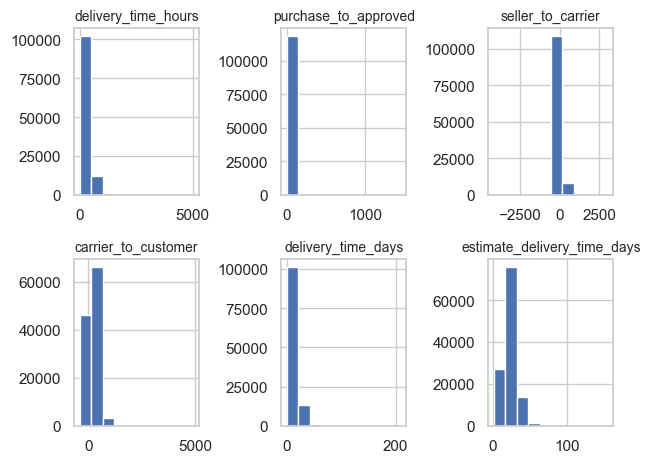

In [79]:
list_col = ['delivery_time_hours','purchase_to_approved','seller_to_carrier','carrier_to_customer','delivery_time_days','estimate_delivery_time_days']
fig, axes = plt.subplots(nrows=2, ncols=3)
for i, col in enumerate(list_col):
    ax = axes[i//3, i%3]
    ax.hist(df_train[col])
    ax.set_title(col, fontsize=10)
plt.tight_layout()
plt.show()

In [65]:
df_train[list_col].describe()

,delivery_time_hours,purchase_to_approved,seller_to_carrier,carrier_to_customer,delivery_time_days,estimate_delivery_time_days
count,115727.000000,118315.000000,117061.000000,115726.000000,115727.000000,118315.000000
mean,299.697945,10.497449,68.521089,220.853480,12.021931,23.504720
std,226.718741,22.202213,85.953298,207.232863,9.452598,8.873607
min,12.801944,0.000000,-4109.256111,-386.308056,0.000000,2.000000
25%,162.082222,0.215556,21.294167,97.541944,6.000000,18.000000
50%,244.858889,0.346944,44.362778,169.502222,10.000000,23.000000
75%,373.369722,14.990417,87.615556,286.321597,15.000000,28.000000
max,5031.086667,1450.866389,3018.301667,4924.583333,209.000000,155.000000


In [83]:
df_train[(df_train['seller_to_carrier'] > 10) & (df_train['carrier_to_customer'] > 10)][list_col].describe()

,delivery_time_hours,purchase_to_approved,seller_to_carrier,carrier_to_customer,delivery_time_days,estimate_delivery_time_days
count,105529.000000,105529.000000,105529.000000,105529.000000,105529.000000,105529.000000
mean,307.657995,9.432829,74.387289,223.837877,12.348786,23.580267
std,229.529171,19.205272,84.179752,210.027925,9.572157,8.795667
min,25.076667,0.000000,10.000833,10.139722,1.000000,2.000000
25%,167.333056,0.213889,25.084722,98.145556,6.000000,18.000000
50%,253.870833,0.334444,49.189444,170.180000,10.000000,23.000000
75%,383.614722,12.979167,92.772778,288.845833,15.000000,28.000000
max,5031.086667,741.443611,2432.670833,4924.583333,209.000000,155.000000


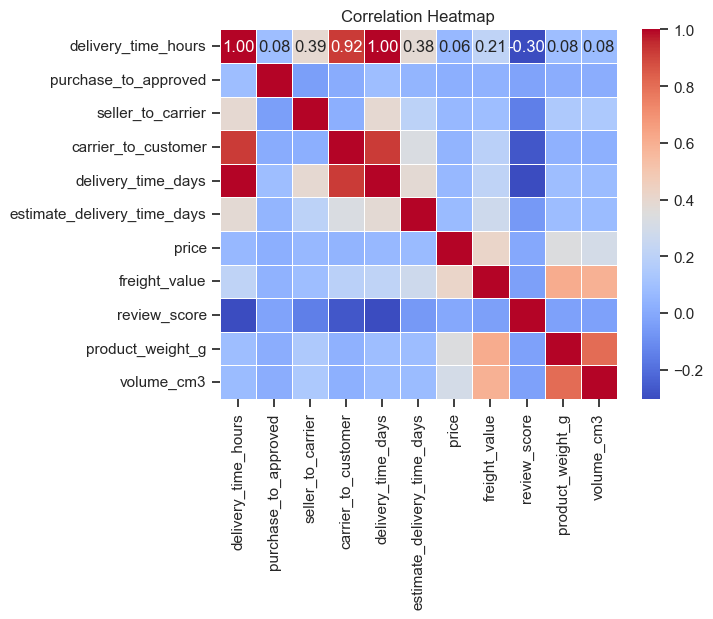

In [66]:
# Calculate the correlation matrix
others_col = ['price','freight_value','review_score','product_weight_g','volume_cm3']
correlation_matrix = df_train[list_col + others_col].corr()
plt.figure() 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

Với bảng correlation ta thấy được mối quan hệ đồng biến (weight ~ volumns). Delivery time ảnh hưởng nghịch biến với review_score, đồng biến với freight_value. Ta cũng thấy carrier_to_customer ~ total delivery time.

In [94]:
df = df_train[(df_train['seller_to_carrier'] > 10) & (df_train['carrier_to_customer'] > 10)][list_col +['freight_value']]
print(df.columns)
df = df.dropna()  
df = df.replace([np.inf, -np.inf], np.nan).dropna()  
df['intercept'] = 1
X = df[['intercept', 'freight_value']]
Y = df['delivery_time_hours']
model = sm.OLS(Y, X).fit()

print(model.summary())

Index(['delivery_time_hours', 'purchase_to_approved', 'seller_to_carrier',
       'carrier_to_customer', 'delivery_time_days',
       'estimate_delivery_time_days', 'freight_value'],
      dtype='object')
                             OLS Regression Results                            
Dep. Variable:     delivery_time_hours   R-squared:                       0.046
Model:                             OLS   Adj. R-squared:                  0.046
Method:                  Least Squares   F-statistic:                     5136.
Date:                 Sun, 19 May 2024   Prob (F-statistic):               0.00
Time:                         10:50:47   Log-Likelihood:            -7.2089e+05
No. Observations:               105529   AIC:                         1.442e+06
Df Residuals:                   105527   BIC:                         1.442e+06
Df Model:                            1                                         
Covariance Type:             nonrobust                                     

<Axes: xlabel='review_score', ylabel='delivery_time_days'>

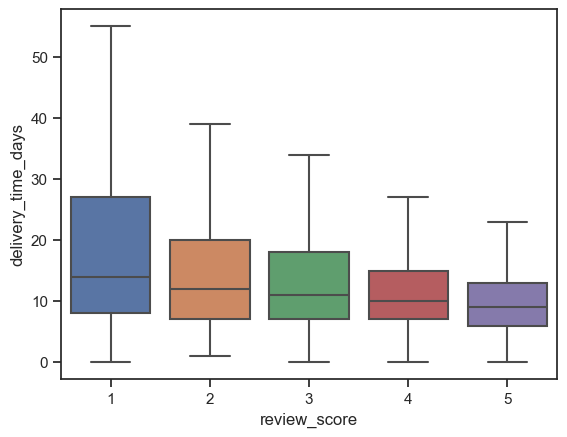

In [67]:
sns.boxplot(data = df_train, x = 'review_score',y='delivery_time_days',showfliers=False)

Text(0.5, 0, '')

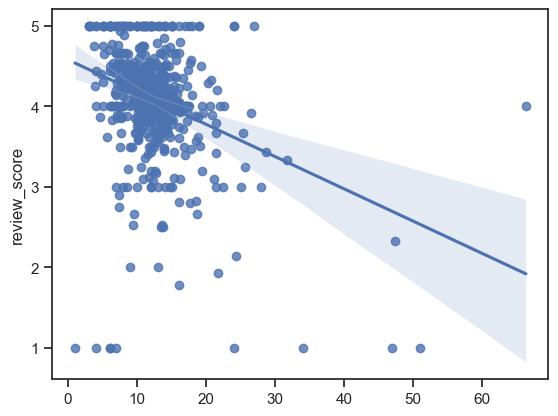

In [89]:
avg_review_score_seller = df_train.groupby('seller_city')[['review_score','delivery_time_days']].mean().dropna().reset_index()
ax = sns.regplot(x="delivery_time_days", y="review_score", data=avg_review_score_seller)
ax.set_xlabel("")

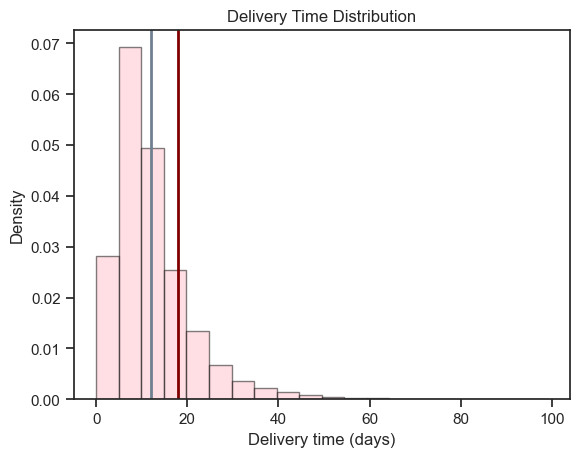

In [68]:
plt.hist(df_train[df_train['delivery_time_days'] < 100].groupby('order_id')['delivery_time_days'].max(), bins=20, density=True, edgecolor='black', color='pink', alpha=0.5)

plt.axvline(12, color='slategray', linewidth=2)
plt.axvline(18, color='maroon', linewidth=2)

# Add labels and title
plt.xlabel('Delivery time (days)')
plt.ylabel('Density')
plt.title('Delivery Time Distribution')
# Display the plot
plt.show()

In [86]:
delivery_data =  df_train[df_train['delivery_time_days'] < 100].groupby('order_id')['delivery_time_days'].max()
percentile = np.sum(delivery_data < 18) / len(delivery_data)
percentile

0.8117227287342731

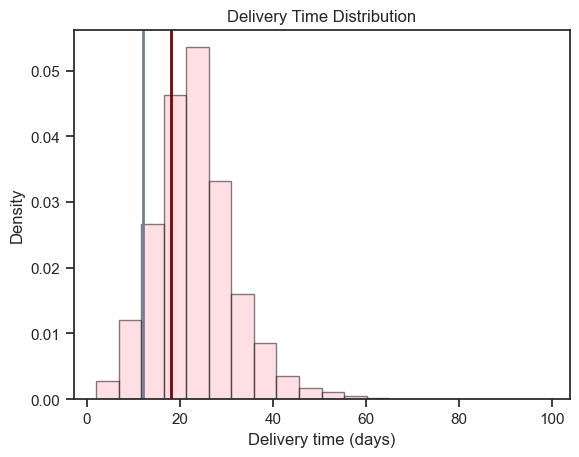

In [70]:
plt.hist(df_train[df_train['estimate_delivery_time_days'] < 100].groupby('order_id')['estimate_delivery_time_days'].max(), bins=20, density=True, edgecolor='black', color='pink', alpha=0.5)

plt.axvline(12, color='slategray', linewidth=2)
plt.axvline(18, color='maroon', linewidth=2)

# Add labels and title
plt.xlabel('Delivery time (days)')
plt.ylabel('Density')
plt.title('Delivery Time Distribution')
# Display the plot
plt.show()

In [71]:
delivery_data =  df_train[df_train['estimate_delivery_time_days'] < 100].groupby('order_id')['estimate_delivery_time_days'].max()
percentile = np.sum(delivery_data < 18) / len(delivery_data)
percentile

0.23322926591927343

In [73]:
# Mối quan hệ giữa thời gian giao hàng và khu vực

<Axes: xlabel='seller_state', ylabel='delivery_time_days'>

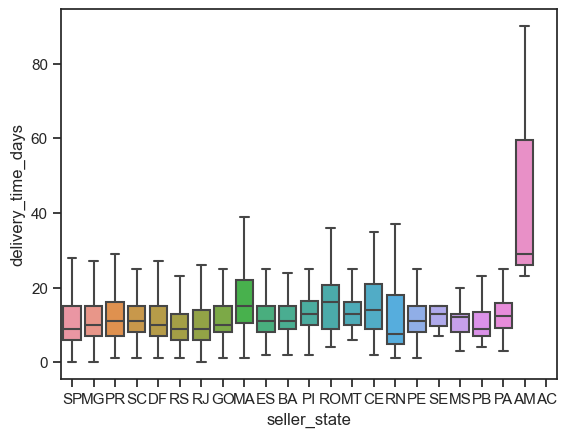

In [84]:
sns.boxplot(data = df_train, x = 'seller_state',y='delivery_time_days',showfliers=False)

<Axes: xlabel='customer_state', ylabel='delivery_time_days'>

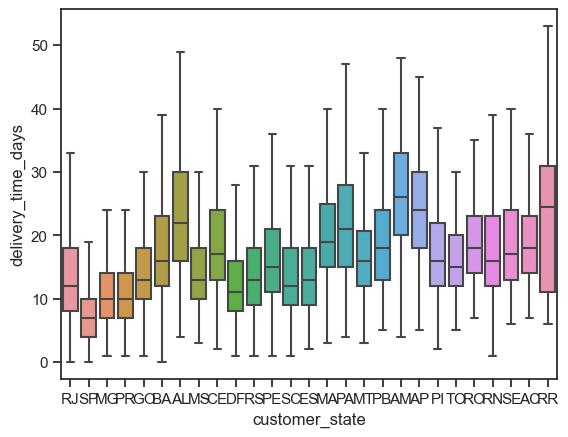

In [85]:
sns.boxplot(data = df_train, x = 'customer_state',y='delivery_time_days',showfliers=False)

/Users/mac/Desktop/1mount/venv/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


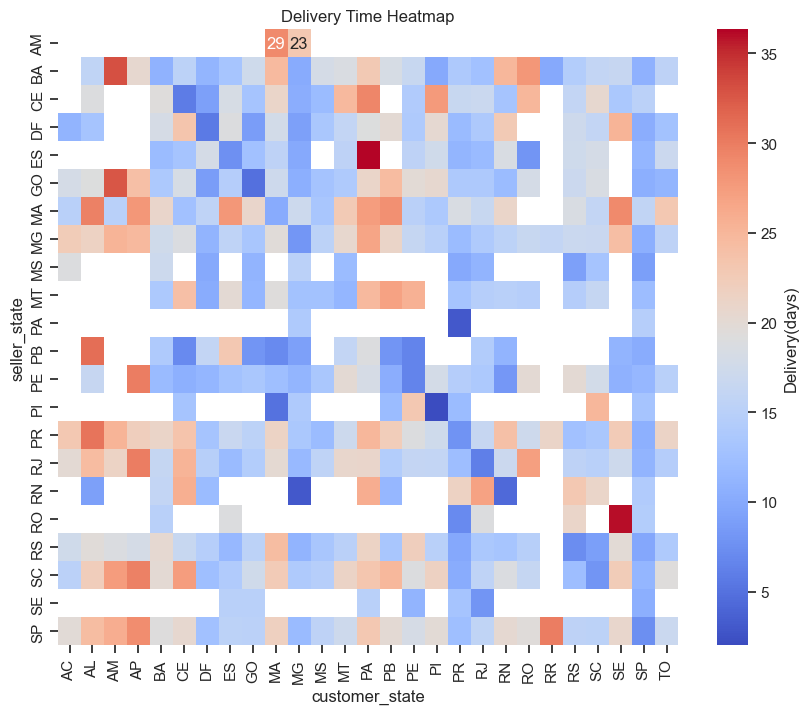

In [99]:
delivery_state = df_train.groupby(['seller_state','customer_state'])['delivery_time_days'].mean().reset_index()
heat_map = delivery_state[delivery_state['delivery_time_days'] < 50].pivot_table(index='seller_state', columns='customer_state', values='delivery_time_days', aggfunc='mean')
# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heat_map, annot=True, fmt="g", cmap="coolwarm", cbar_kws={'label': 'Delivery(days)'})
plt.title('Delivery Time Heatmap')
plt.show()

In [100]:
heat_map

customer_state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
seller_state,,,,,,,,,,,,,,,,,,,,,
AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BA,NaN,15.700000,33.000000,20.500000,10.853659,15.312500,11.210526,13.230769,17.384615,24.588235,...,13.923077,12.677083,25.000000,28.000000,10.000000,14.416667,16.000000,16.444444,10.831395,15.500000
CE,NaN,19.000000,NaN,NaN,19.333333,5.888889,9.000000,18.333333,13.000000,21.000000,...,16.600000,16.800000,13.000000,25.000000,NaN,16.000000,20.500000,13.666667,15.153846,NaN
DF,11.000000,13.000000,NaN,NaN,18.125000,23.357143,5.650794,18.961538,8.750000,17.818182,...,11.848485,13.887850,22.750000,NaN,NaN,17.173913,16.000000,25.333333,10.413295,12.777778
ES,NaN,NaN,NaN,NaN,12.025641,13.000000,18.000000,7.555556,12.666667,15.500000,...,11.125000,11.866667,18.500000,8.000000,NaN,17.333333,18.076923,NaN,11.380165,17.000000
GO,18.000000,19.142857,32.666667,24.000000,13.750000,18.307692,8.793103,14.600000,4.948718,17.285714,...,13.904762,13.875000,12.000000,18.000000,NaN,16.916667,18.545455,NaN,10.476821,11.200000
MA,15.000000,29.750000,15.000000,28.000000,20.833333,12.666667,15.678571,28.000000,20.823529,10.066667,...,18.555556,16.604651,21.000000,NaN,NaN,18.588235,16.000000,29.000000,15.832061,23.000000
MG,22.454545,21.564103,25.266667,24.666667,17.510112,18.849462,11.119469,15.557692,13.333333,19.681159,...,11.946136,14.060940,15.305556,16.562500,16.000000,16.852507,16.631034,24.232558,10.454872,15.529412
MS,19.000000,NaN,NaN,NaN,17.076923,NaN,10.000000,NaN,11.000000,NaN,...,10.000000,11.000000,NaN,NaN,NaN,9.000000,13.000000,NaN,8.842105,NaN


In [101]:
region_state =  {'North':['AC','AM','RR','AP','PA','RO','TO'],
                'NorthEast':['MA','PI','CE','RN','PB','PE','AL','SE','BA'],
                'CentralWest':['MT','DF','GO','MS'],
                'SouthEast':['SP','MG','ES','RJ'],
                'South':['PR','SC','RS']}
state_to_region = {state: region for region, states in region_state.items() for state in states}
df_train['seller_region_state'] = df_train['seller_state'].map(state_to_region)
df_train['customer_region_state'] = df_train['customer_state'].map(state_to_region)

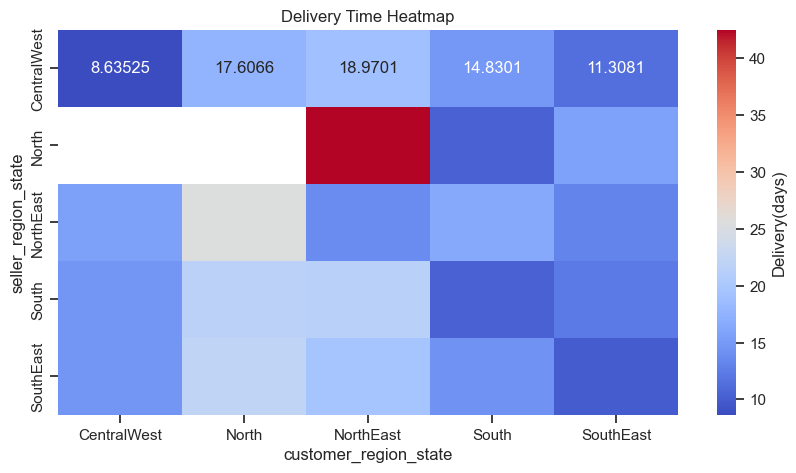

In [102]:
delivery_region = df_train.groupby(['seller_region_state','customer_region_state'])['delivery_time_days'].mean().reset_index()
heat_map = delivery_region[delivery_region['delivery_time_days']<10000].pivot_table(index='seller_region_state', columns='customer_region_state', values='delivery_time_days', aggfunc='mean')
# Vẽ heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heat_map, annot=True, fmt="g", cmap="coolwarm", cbar_kws={'label': 'Delivery(days)'})
plt.title('Delivery Time Heatmap')
plt.show()

In [98]:
heat_map

customer_region_state,CentralWest,North,NorthEast,South,SouthEast
seller_region_state,,,,,
CentralWest,8.635246,17.606557,18.970149,14.830065,11.308071
North,NaN,NaN,42.500000,10.333333,15.722222
NorthEast,15.525926,25.529412,13.693227,16.564972,13.132743
South,14.673768,21.639130,21.356994,10.268912,12.313133
SouthEast,14.674052,22.148526,19.507478,14.400476,9.891243


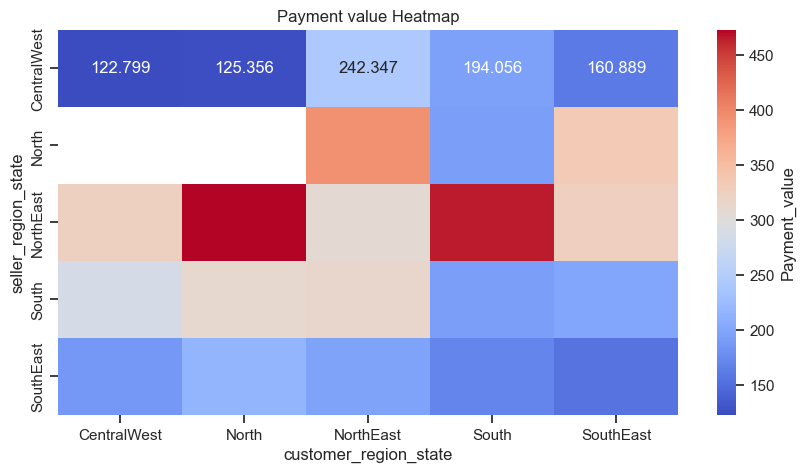

In [106]:
delivery_region = df_train.groupby(['seller_region_state','customer_region_state'])['payment_value'].mean().reset_index()
heat_map = delivery_region.pivot_table(index='seller_region_state', columns='customer_region_state', values='payment_value', aggfunc='sum')
# Vẽ heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heat_map, annot=True, fmt="g", cmap="coolwarm", cbar_kws={'label': 'Payment_value'})
plt.title('Payment value Heatmap')
plt.show()

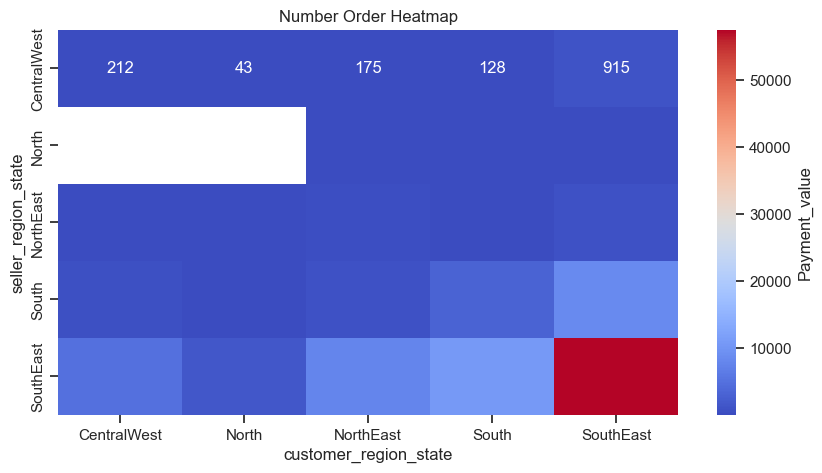

In [116]:
delivery_region = df_train.groupby(['seller_region_state','customer_region_state','order_purchase_timestamp'])['order_id'].count().reset_index()
delivery_region = delivery_region.groupby(['seller_region_state','customer_region_state'])['order_id'].count().reset_index()
heat_map = delivery_region.pivot_table(index='seller_region_state', columns='customer_region_state', values='order_id', aggfunc='sum')
# Vẽ heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heat_map, annot=True, fmt="g", cmap="coolwarm", cbar_kws={'label': 'Payment_value'})
plt.title('Number Order Heatmap')
plt.show()

In [104]:
heat_map

customer_region_state,CentralWest,North,NorthEast,South,SouthEast
seller_region_state,,,,,
CentralWest,212.0,43.0,175.0,128.0,915.0
North,NaN,NaN,4.0,3.0,19.0
NorthEast,123.0,46.0,445.0,145.0,807.0
South,658.0,208.0,875.0,3135.0,8423.0
SouthEast,4745.0,1545.0,7831.0,10665.0,57462.0


In [98]:
groupby_product_old_customer = df_train.groupby('product_category_name')[['payment_value','delivery_time_days','review_score','order_id']].agg(
    {'payment_value':'sum','delivery_time_days':'mean','review_score':'mean','order_id':'nunique'}
).reset_index().sort_values(by='order_id',ascending = False)
total_order = groupby_product_old_customer['order_id'].sum()
groupby_product_old_customer['pct_total'] = 100*(groupby_product_old_customer['order_id']/total_order)
groupby_product_old_customer.head(10)

,product_category_name,payment_value,delivery_time_days,review_score,order_id,pct_total
7,bed_bath_table,1744205.53,12.331838,3.867056,9417,9.467271
43,health_beauty,1663076.30,11.528423,4.119143,8835,8.882164
66,sports_leisure,1400270.11,11.663217,4.092837,7720,7.761212
15,computers_accessories,1599574.66,12.805224,3.926144,6689,6.724708
39,furniture_decor,1444383.69,12.387321,3.895279,6449,6.483427
49,housewares,1097900.09,10.519872,4.045257,5884,5.915411
71,watches_gifts,1430553.48,12.226831,4.000644,5624,5.654023
69,telephony,487189.71,12.402865,3.938214,4199,4.221416
5,auto,855095.68,11.748198,4.038636,3897,3.917804
70,toys,619975.71,11.231576,4.142490,3886,3.906745


## Review Score

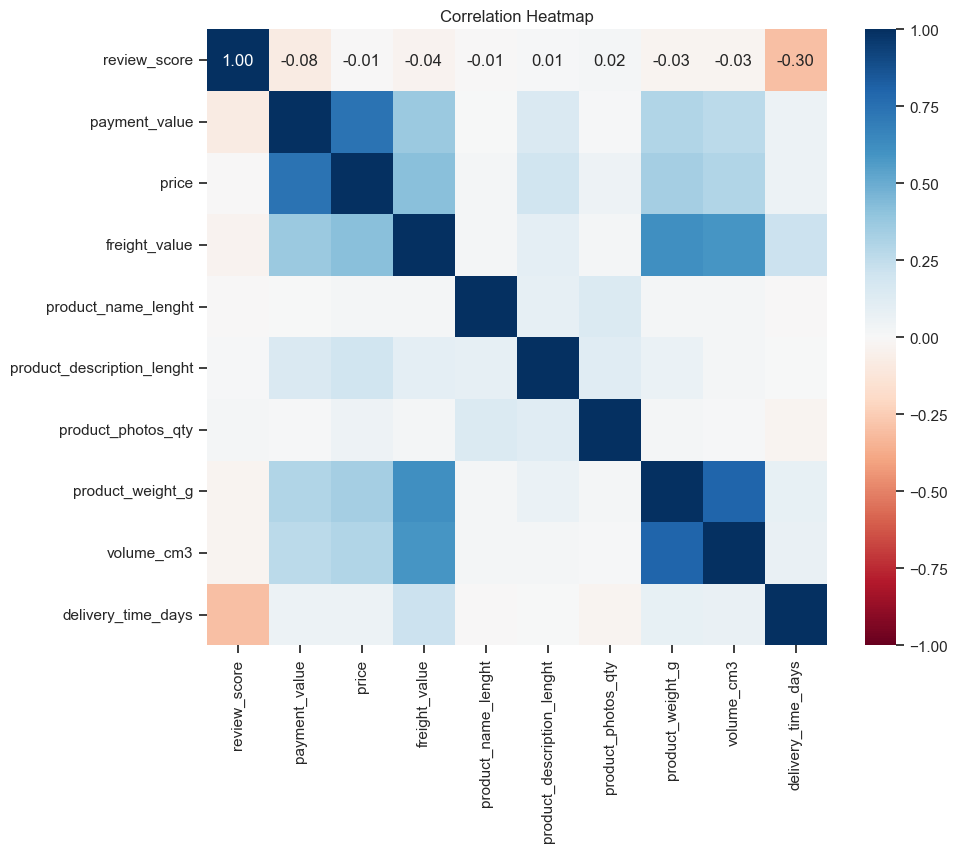

In [109]:
numeric_columns = ['review_score', 'payment_value', 'price', 'freight_value', 'product_name_lenght',
                   'product_description_lenght', 'product_photos_qty', 'product_weight_g',
                   'volume_cm3','delivery_time_days']
numeric_df = df_train[numeric_columns]
corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='RdBu', norm=plt.Normalize(-1,1), annot=True, fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

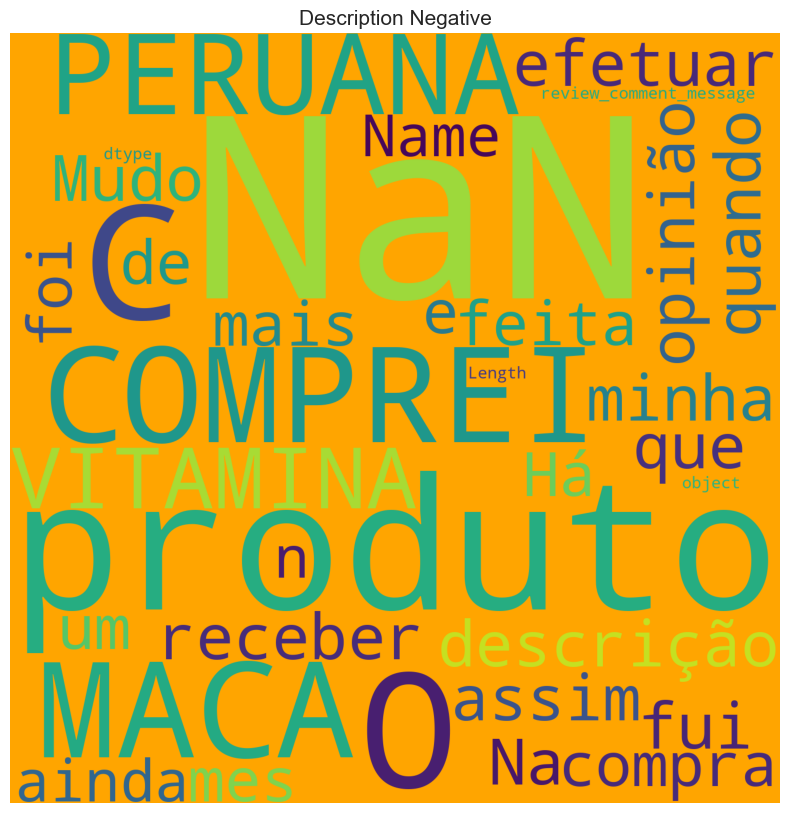

In [111]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('fast')

wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(df_train[df_train['review_score'].isin([1,2])]['review_comment_message']))
plt.title('Description Negative', fontsize = 15)

plt.imshow(wc)
plt.axis('off')
plt.show()

In [109]:
df = df_train[(df_train['seller_to_carrier'] > 10) & (df_train['carrier_to_customer'] > 10)][['review_score','product_photos_qty','product_description_lenght']]

df = df.dropna()  
df = df.replace([np.inf, -np.inf], np.nan).dropna()  
df['intercept'] = 1
X = df[['intercept', 'product_photos_qty','product_description_lenght']]
Y = df['review_score']
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     36.26
Date:                Sun, 19 May 2024   Prob (F-statistic):           1.80e-16
Time:                        12:25:10   Log-Likelihood:            -1.8010e+05
No. Observations:              103987   AIC:                         3.602e+05
Df Residuals:                  103984   BIC:                         3.602e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept           

In [112]:
# Model to predict

In [113]:
df = df_train.copy()
df['new_review_score'] = df['review_score'].apply(lambda x: 1 if x < 3 else 0)

# Define Features and Target
X = df.drop('new_review_score', axis=1)
y = df['new_review_score']
numeric_features = ['delivery_time_days','payment_value','product_photos_qty','volume_cm3','product_description_lenght']
categorical_features = ['seller_region_state','customer_region_state']
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Evaluate the Model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     19699
           1       0.78      0.49      0.61      3964

    accuracy                           0.89     23663
   macro avg       0.84      0.73      0.77     23663
weighted avg       0.88      0.89      0.88     23663

